## Data Challenge 4 ##
### Dan Hannah, Healthcare Data Science, Insight Data Science ###
Our goal is to understand whether players with a dark skin tone are given significantly more red cards than players with lighter skin tones.

In [69]:
# A few globally useful imports.
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Global settings to make plots more legible.
plt.rcParams['figure.figsize'] = (10, 8)
plt.rcParams['axes.labelsize'] = 24
plt.rcParams['xtick.labelsize'] = 20
plt.rcParams['ytick.labelsize'] = 20
plt.rcParams['font.sans-serif'] = 'DejaVu Sans'

### 1) Data Cleaning ###
I'll start by reading the data and seeing how it is structured.

In [2]:
df = pd.read_csv("redcard.csv")
df.head().T  # For many features, the transpose is easier to read.

,0,1,2,3,4
playerShort,lucas-wilchez,john-utaka,abdon-prats,pablo-mari,ruben-pena
player,Lucas Wilchez,John Utaka,Abdón Prats,Pablo Marí,Rubén Peña
club,Real Zaragoza,Montpellier HSC,RCD Mallorca,RCD Mallorca,Real Valladolid
leagueCountry,Spain,France,Spain,Spain,Spain
birthday,31.08.1983,08.01.1982,17.12.1992,31.08.1993,18.07.1991
height,177,179,181,191,172
weight,72,82,79,87,70
position,Attacking Midfielder,Right Winger,NaN,Center Back,Right Midfielder
games,1,1,1,1,1
victories,0,0,0,1,1


One of the first thing that stands out is there are several players who have no skin tone rating.  I'm going to drop them from the get-go, as they presumably won't be informative for answering the question at hand.

In [3]:
len(df)

146028

In [4]:
df.dropna(how="all", subset=['rater1', 'rater2'], inplace=True)
len(df)

124621

Over 100,000 records are retained, still plenty for data analysis.

### 2) Exploratory data analysis ###

I'll start simple and ask, with the most generality - do darker skinned players get more red cards? Because the data set is in the form of player-referee dyads, I first need to see how many red cards are given per player, then look at any possible correlation between skin tone and and red card count. This approach is naive with regard to certain players encoutering referees more often, especially more biased (as determined from implicit and explicit racial bias scores) referees. This is something I will attempt to address later. First, I need to look at whether the raters agree on skin tone.

In [77]:
rater1_values = df.groupby(by='playerShort')['rater1'].mean()
rater2_values = df.groupby(by='playerShort')['rater2'].mean()

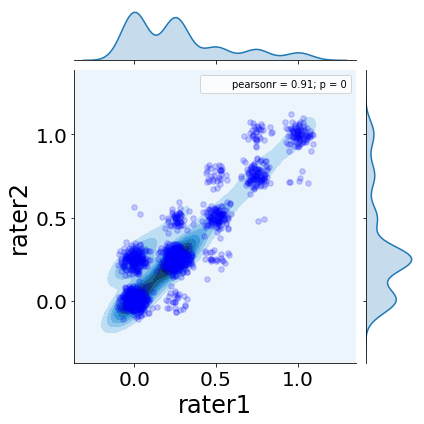

In [75]:
jitter_x = np.random.normal(0, 0.04, size=len(rater1_values))
jitter_y = np.random.normal(0, 0.04, size=len(rater2_values))
g = sns.jointplot(rater1_values + jitter_x, rater2_values + jitter_y, kind='kde')
g.plot_joint(plt.scatter, c="b", s=30, linewidth=1, alpha=0.2)
plt.show()

The joint plot above makes it clear that rater 1 and rater 2 _usually_ agree, but not always. In particular, it seems that rater 2 seems to rate players' skin as being slightly darker than rater 1, particularly in the low (lighter) regions.  Because the skin ratings are ranked and ordered (a difference between 1 and 4 and 1 and 2 is a very different sort of disagreement), a Wilcoxon signed rank test seems appropriate to determine if these ratings are truly different.  In this case, the following hypotheses are being tested:

$H_0$: Rater 1 and rater 2 do not rate skin tones as lighter or darker than the other.

$H_1$: Rater 1 and rater 2 are shifted, with one person on average issuing lighter or darker ratings than the other.

In [76]:
import scipy.stats as stats
stats.wilcoxon(rater1_values, rater2_values)

WilcoxonResult(statistic=10962.0, pvalue=1.4502902042062533e-41)

On the basis of the Wilcoxon Signed Rank test, a significant difference exists between rater 1 and rater 2, with rater 2 issuing darker skin tone ratings more often than rater 1. Ideally, a third rater would allow for some type of tie-breaking, but in the absence of additional data, it is difficult to know which rater (if either) is more reliable. For simplicity, I will average the ratings of rater 1 and rater 2 to get a measure of the player's skin tone.  However, I am aware this may be problematic - a Wilcoxon signed-rank test, effectively, looks at whether pairwise differences in the two data sets (skin tone ratings) are symmetric about zero. As the significant difference and joint distribution plot above makes clear, they are not, so the averaging may not be an entirely appropriate assumption in this instance.

In [81]:
rater_avg_values = 0.5 * (rater1_values + rater2_values)

The next piece of the puzzle when it comes to a "fair" assessment is the number of games a player has played. There may be players of varying seniority in the data set.

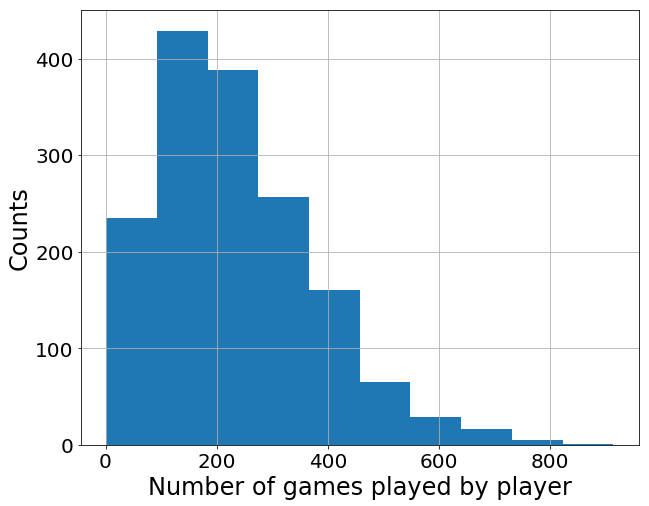

In [83]:
games_by_player = df.groupby(by='playerShort')['games'].sum()
games_by_player.hist()
plt.xlabel("Number of games played by player")
plt.ylabel("Counts")
plt.show()

There is clearly quite a spread here (with some players having played more than 600 games!). I don't want to misleadingly label a player as having received many red cards simply because that player was receiving them at a low rate but over the course of many games. To account for this, I'll set up my analysis in terms of red card rate.

In [85]:
redcards_by_player = df.groupby(by='playerShort')['redCards'].sum()
redcards_per_game_by_player = redcards_by_player / games_by_player

Another potentially confounding effect to be aware of is the role of position - some positions in soccer seem to be more aggressive than others, and these positions may result in more red cards. If dark skinned players play these positions more often _and_ receive more red cards, it may be difficult to de-correlate such effects. I use the mean and not the sum to account for the fact that certain positions may show up more in the data set and will naturally accrue more redcards as a result.

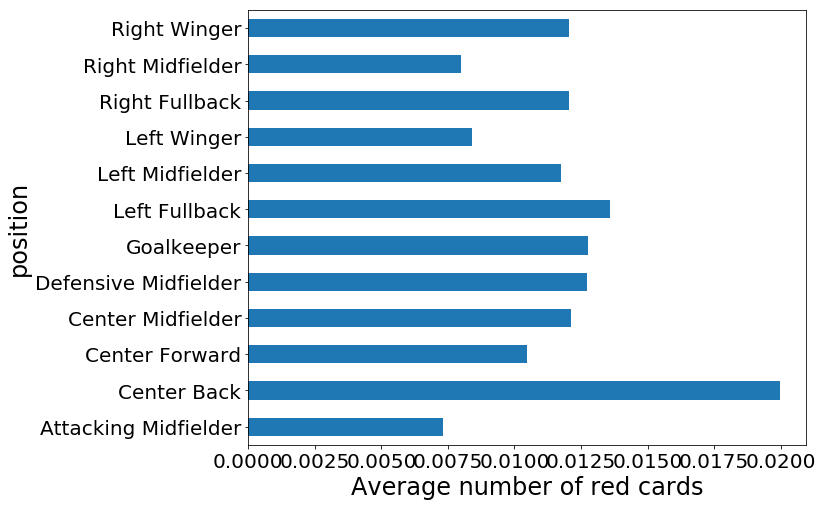

In [100]:
redcards_by_position = df.groupby(by='position')['redCards'].mean()
redcards_by_position.plot(kind='barh')
plt.xlabel("Average number of red cards")
plt.show()

It appears that center backs accrue more redcards than other positions, with most of the other positions having a much cloesr average redcard count. For now, I'm going to look at the whole data set, and I will analyze center back separately if time permits.

### 3) Do referees give more red cards to darker skinned players? ###
I've set up my data in a way that lets me make a first-pass assessment across all referees and countries, to try to provide a simple answer to this question. As time and data permit, there are many interesting avenues for deeper analysis, but I'll start by simply looking at whether darker skin is associated with a higher red card per game count.

In [115]:
df_players = df.groupby(by='playerShort').mean()

In [132]:
df_players_with_avg = df_players.join([rater_avg_values, redcards_per_game_by_player])
df_players_with_avg.rename(columns={0: 'rater_avg_values', 1: 'recards_per_game'}, inplace=True)

In [133]:
df_players_with_avg.head().T

playerShort,aaron-hughes,aaron-hunt,aaron-lennon,aaron-ramsey,abdelhamid-el-kaoutari
height,182.000000,183.000000,165.000000,178.000000,180.000000
weight,71.000000,73.000000,63.000000,76.000000,73.000000
games,3.939759,3.393939,4.079208,2.500000,3.351351
victories,1.487952,1.424242,1.980198,1.442308,1.108108
ties,1.078313,0.737374,0.960396,0.403846,1.081081
defeats,1.373494,1.232323,1.138614,0.653846,1.162162
goals,0.054217,0.626263,0.306931,0.375000,0.027027
yellowCards,0.114458,0.424242,0.108911,0.298077,0.216216
yellowReds,0.000000,0.000000,0.000000,0.000000,0.108108
redCards,0.000000,0.010101,0.000000,0.009615,0.054054


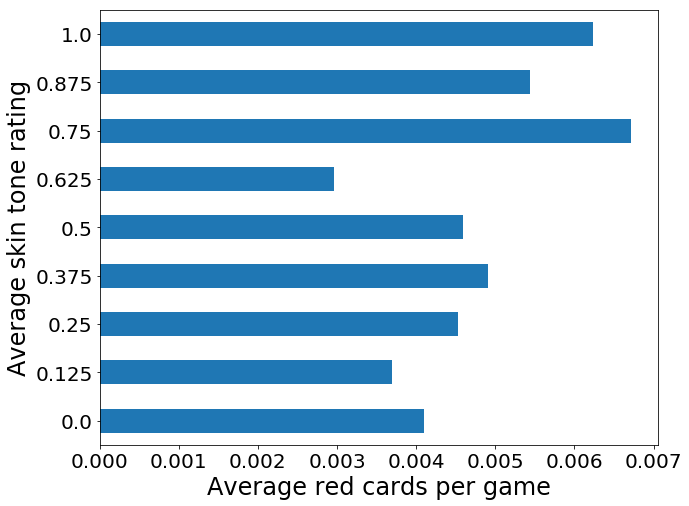

In [141]:
df_players_with_avg.groupby(by='rater_avg_values')['recards_per_game'].mean().plot(kind='barh')
plt.ylabel("Average skin tone rating")
plt.xlabel("Average red cards per game")
plt.show()

It would appear that darker-skinned players (particularly the top 3 categories) get more red cards than lighter skinned players. For simplicity, I will bin these categories instead into "dark-skinned" (> 0.5) and "light skinned" (<= 0.5).

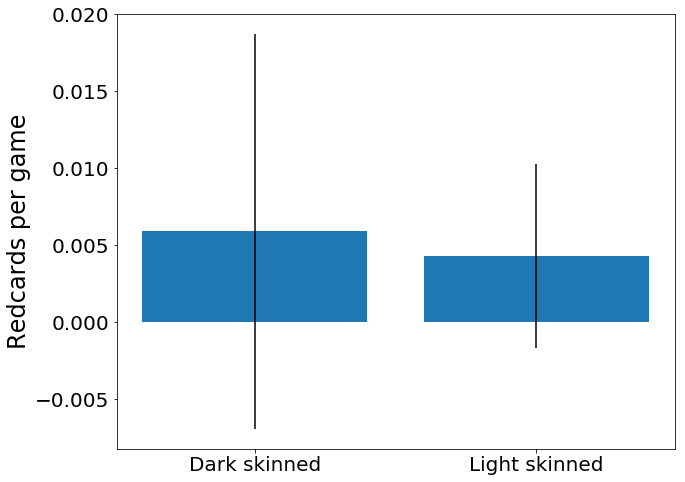

In [159]:
darkskinned_players = df_players_with_avg[df_players_with_avg["rater_avg_values"] > 0.5]
lightskinned_players = df_players_with_avg[df_players_with_avg["rater_avg_values"] <= 0.5]
means = [darkskinned_players['recards_per_game'].mean(), lightskinned_players['recards_per_game'].mean()]
stderrs = [darkskinned_players['recards_per_game'].std(), lightskinned_players['recards_per_game'].std()]
plt.bar([0, 1], means, yerr=stderrs)
plt.xticks([0, 1], ['Dark skinned', 'Light skinned'])
plt.ylabel("Redcards per game")
plt.show()

It appears that dark skinned players do receive more red cards per game, albeit with a large standard deviation. Because the redcards per game quantity as a continuous value and these two categories are mutually exclusive (i.e. independent), I'm going to perform a t-test to see if the differences are statistically significant, however, in light of the radically different sample sizes and different variances, I will perform a Welch's t-test.

In [154]:
stats.ttest_ind(darkskinned_players['recards_per_game'], lightskinned_players['recards_per_game'], equal_var=False)

Ttest_indResult(statistic=2.0308981331869491, pvalue=0.043170867989629332)

The small $p$-value above (0.04) indicates that dark skinned players _do_ receive significantly more red cards than light skinned players, although only with respect to the usual $\alpha = 0.05$ value.

### 4) Conclusions ###
1) Some players are missing skin tone ratings.

2) Rater 2 rates player skin tones as generally being slightly darker than rater 1, particularly for light skinned players.

3) Dark skinned players do, on average, receive more red cards, although barely ($p$ = 0.04) in a Welch's $t$-test.

### 5) Future work ###
* The data set contains a lot of info about referee bias. The first thing I would like to check is whether bias scores are associated with more red cards given to darker skinned players.
* Center backs receive markedly more redcards than any other position - if this position is played disproportionately often by dark skinned players, then I would compare the red card penalties within this position across skin color to see if position assignments were responsible for the difference.